# Backprop - numpy version

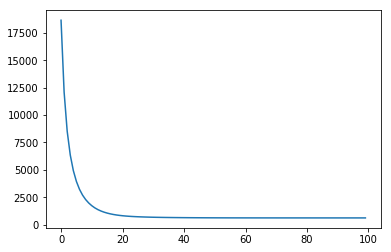

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 64
D_in = 10
H1 = 3
H2 = 3
D_out = 10

x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

w1 = np.random.randn(D_in, H1)
w2 = np.random.randn(H1, H2)
w3 = np.random.randn(H2, D_out)

lr = 10**-5

losses = []
for i in range(100):
    
    h1 = x.dot(w1)
    h1_relu = np.maximum(h1, 0)
    
    h2 = h1_relu.dot(w2)
    h2_relu = np.maximum(h2, 0)
    
    y_pred = h2_relu.dot(w3)
    
    loss = np.square(y_pred - y).sum()
    #print(i, loss)
    losses.append(loss)
    
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w3 = h2_relu.T.dot(grad_y_pred)
    
    grad_h2_relu = grad_y_pred.dot(w3.T)
    grad_h2 = grad_h2_relu.copy()
    grad_h2[h2 < 0] = 0
    grad_w2 = h1_relu.T.dot(grad_h2)
    
    grad_h1_relu = grad_h2.dot(w2.T)
    grad_h1 = grad_h1_relu.copy()
    grad_h1[h1 < 0] = 0
    grad_w1 = x.T.dot(grad_h1)
    
    w1 -= lr * grad_w1
    w2 -= lr * grad_w2
    w3 -= lr * grad_w3

plt.plot(losses)

# Backprop - tensorflow

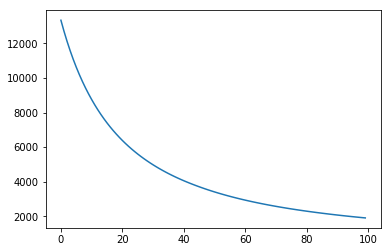

In [2]:
import tensorflow as tf
import numpy as np

N = 64
D_in = 10
H1 = 3
D_out = 10

g = tf.Graph()

with g.as_default():
    x = tf.placeholder(tf.float32, shape=(None, D_in))
    y = tf.placeholder(tf.float32, shape=(None, D_out))

    w1 = tf.Variable(tf.random_normal((D_in, H1)))
    w2 = tf.Variable(tf.random_normal((H1, D_out)))

    h = tf.matmul(x, w1)
    h_relu = tf.maximum(h, tf.zeros(1))
    y_pred = tf.matmul(h_relu, w2)

    loss = tf.reduce_sum((y-y_pred)**2.0)

    grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])

    lr = 10**-5
    new_w1 = w1.assign(w1 - lr * grad_w1)
    new_w2 = w2.assign(w2 - lr * grad_w2)

losses = []

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    x_value = np.random.randn(N, D_in)
    y_value = np.random.randn(N, D_out)
    
    for _ in range(100):
        loss_val, _, _ = sess.run([loss, new_w1, new_w2], feed_dict={x:x_value, y:y_value})
        losses.append(loss_val)
    
plt.plot(losses)

# Backprop - pyTorch

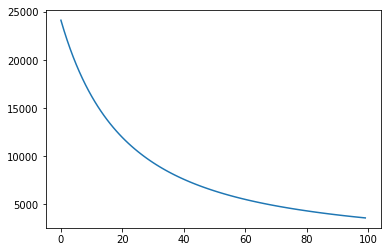

In [3]:
import torch

#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor

N = 64
D_in = 10
H1 = 10
D_out = 10

x = torch.randn(N, D_in).type(dtype)
y = torch.randn(N, D_out).type(dtype)

w1 = torch.randn(D_in, H1).type(dtype)
w2 = torch.randn(H1, D_out).type(dtype)

lr = 10**-5

losses = []
for i in range(100):
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    
    loss = (y_pred - y).pow(2).sum()
    losses.append(loss)
    
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)
    
    w1 -= lr * grad_w1
    w2 -= lr * grad_w2
    
plt.plot(losses)

# pyTorch - autograd

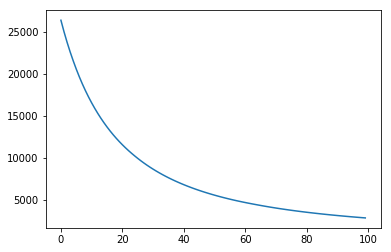

In [4]:
import torch
from torch.autograd import Variable


class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    def forward(self, input):
        """
        In the forward pass we receive a Tensor containing the input and return a
        Tensor containing the output. You can cache arbitrary Tensors for use in the
        backward pass using the save_for_backward method.
        """
        self.save_for_backward(input)
        return input.clamp(min=0)

    def backward(self, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input
    

dtype = torch.cuda.FloatTensor

N = 64
D_in = 10
H1 = 10
D_out = 10

x = Variable(torch.randn(N, D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, D_out).type(dtype), requires_grad=False)

w1 = Variable(torch.randn(D_in, H1).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H1, D_out).type(dtype), requires_grad=True)

lr = 10**-5
losses = []
for i in range(100):
    relu = MyReLU()
    
    # y_pred = x.mm(w1).clamp(min=0).mm(w2)
    y_pred = relu(x.mm(w1)).mm(w2)
    
    loss = (y_pred - y).pow(2).sum()
    losses.append(loss.data[0])
    
    loss.backward()
    
    w1.data -= lr * w1.grad.data
    w2.data -= lr * w2.grad.data
    
    # Manually zero the gradients after updating weights
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    
plt.plot(losses)

# pyTorch - nn module

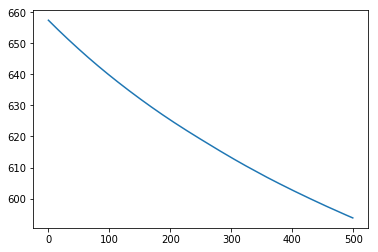

In [24]:
import torch
from torch.autograd import Variable

N = 64
D_in = 10
H1 = 10
D_out = 10


dtype = torch.cuda.FloatTensor

x = Variable(torch.randn(N, D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, D_out).type(dtype), requires_grad=False)

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, D_out)
)
model.cuda()

loss_fn = torch.nn.MSELoss(size_average=False)

learning_rate = 10.**-4.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for i in range(500):
    
    y_pred = model(x)
    
    loss = loss_fn(y_pred, y)
    losses.append(loss.data[0])
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
plt.plot(losses)
    

# pyTorch - custom nn modules

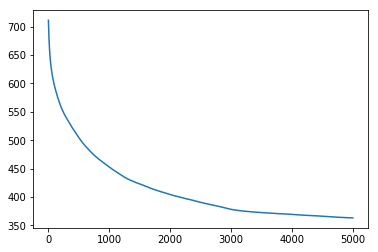

In [26]:
import torch
from torch.autograd import Variable

N = 64
D_in = 10
H1 = 10
D_out = 10

class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred
    
dtype = torch.cuda.FloatTensor

x = Variable(torch.randn(N, D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, D_out).type(dtype), requires_grad=False)


loss_fn = torch.nn.MSELoss(size_average=False)

model = TwoLayerNet(D_in, H1, D_out)
model.cuda()

learning_rate = 10.**-4.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []
for i in range(5000):
    
    y_pred = model(x)
    
    loss = loss_fn(y_pred, y)
    losses.append(loss.data[0])
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
plt.plot(losses)

# PyTorch: Control Flow + Weight Sharing

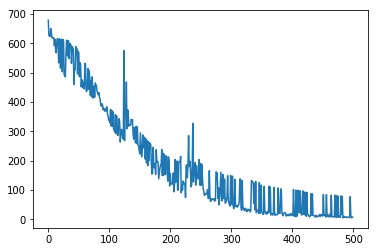

In [29]:
import random
import torch
from torch.autograd import Variable


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 10, 100, 10

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad=False)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

losses = []
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    losses.append(loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(losses)